# 3.1. MNIST 세트

In [1]:
#from sklearn.datasets import fetch_openml
#mnist = fetch_openml("mnist_784", version = 1, cache = True)
#mnist

In [2]:
import pandas as pd
import numpy as np

X = np.array(pd.read_csv("Ch3.Mnist_X.csv"))
y = np.array(pd.read_csv("Ch3.Mnist_y.csv"))

In [3]:
#X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000, 1)

In [5]:
y = y.reshape(-1,)

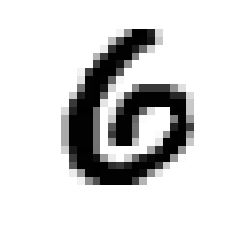

In [6]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[3950]
some_digit_image = some_digit.reshape(28, 28) #28x28이미지임
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
          interpolation = "nearest")
plt.axis("off")
plt.show()

In [7]:
y[3950]

6

- mnist는 훈련용 데이터와 테스트 데이터를 따로 구분해놓음
    - 앞 쪽 60,000개 vs 뒤 쪽 나머지

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
#훈련세트를 섞어서 모든 교차 폴드가 비슷해지게 만드는 과정
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# 3.2. 이진 분류기 훈련
- 문제를 단순화한다고 생각하고, 5만 식별하도록 해보자
- 즉, 5와 5가 아닌 것으로 이진분류하는 분류기를 만들어보자
- 분류 작업을 위한 타겟 벡터를 만들어보자

In [10]:
#5인 놈들은 True(1), 아닌 놈들은 False(0)으로 반환
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

- SGD 분류기를 한 번 활용해보자
    - 매우 큰 데이터 셋을 효과적으로 처리하는 장점이 있음
    - 한 번에 하나씩 훈련샘플을 독립적으로 처리하기 때문임
        - 그래서 온라인 학습에 굉장히 적합함

In [11]:
np.unique(y_train_5)

array([False,  True])

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 5, random_state = 32)
sgd_clf.fit(X_train, y_train_5)

C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=32, shuffle=True, tol=0.001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([False])

- 일단 some_digit이 6이었으므로 정확히 예측하긴 했음
- 전체적으로 살펴보며 성능을 측정해보자

# 3.3. 성능측정
- Classification의 경우 Regression보다 훨씬 평가가 어려움
- 사용할 수 있는 성능지표가 많으므로, 해당 지표들을 학습할 필요가 있음

## 3.3.1. CV를 활용한 정확도 측정
- CV는 Regression에서처럼 Classification에서도 좋은 방법론임

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.94385, 0.96065, 0.96435])

- 성능이 매우 좋아보임
- 그러나 한 가지 함정이 있음
- 절대 5가 아님을 출력하는 분류기를 만들어보자

In [15]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1), dtype = bool) #False로 반환하는 것

In [16]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91045, 0.9087 , 0.9098 ])

- 5가 아닌 데이터와 5인 데이터의 비율이 애초에 9:1임
- 그래서 아니라고 말해도 이미 90%의 정확도를 보여줄 수 밖에없음
- 이 예제는 "accuracy"를 왜 분류기의 성능 측정 지표로 잘 활용하지 않는지를 보여줌
    - 특히 imbalanced Dataset을 다룰 때 더욱 그러함

## 3.3.2. Confusion Matrix(오차행렬)
- 정확도는 위의 문제가 있어서 구림
- 그래서 더 좋은 방법론이 있으니 CM임
- 오차 행렬을 만드려면, 실제 타깃과 비교할 수 있는 실제 예측값을 만들 필요가 있음
- cross_val_predict()를 활용할 수 있음

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [18]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53029,  1550],
       [ 1073,  4348]], dtype=int64)

- CM의 행 -> 실제 클래스
- CM의 열 -> 예측 클래스
- 완벽한 분류기라면 CM이 아래와같은 결과를 보여줘야함

In [19]:
confusion_matrix(y_train_5, y_train_5)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

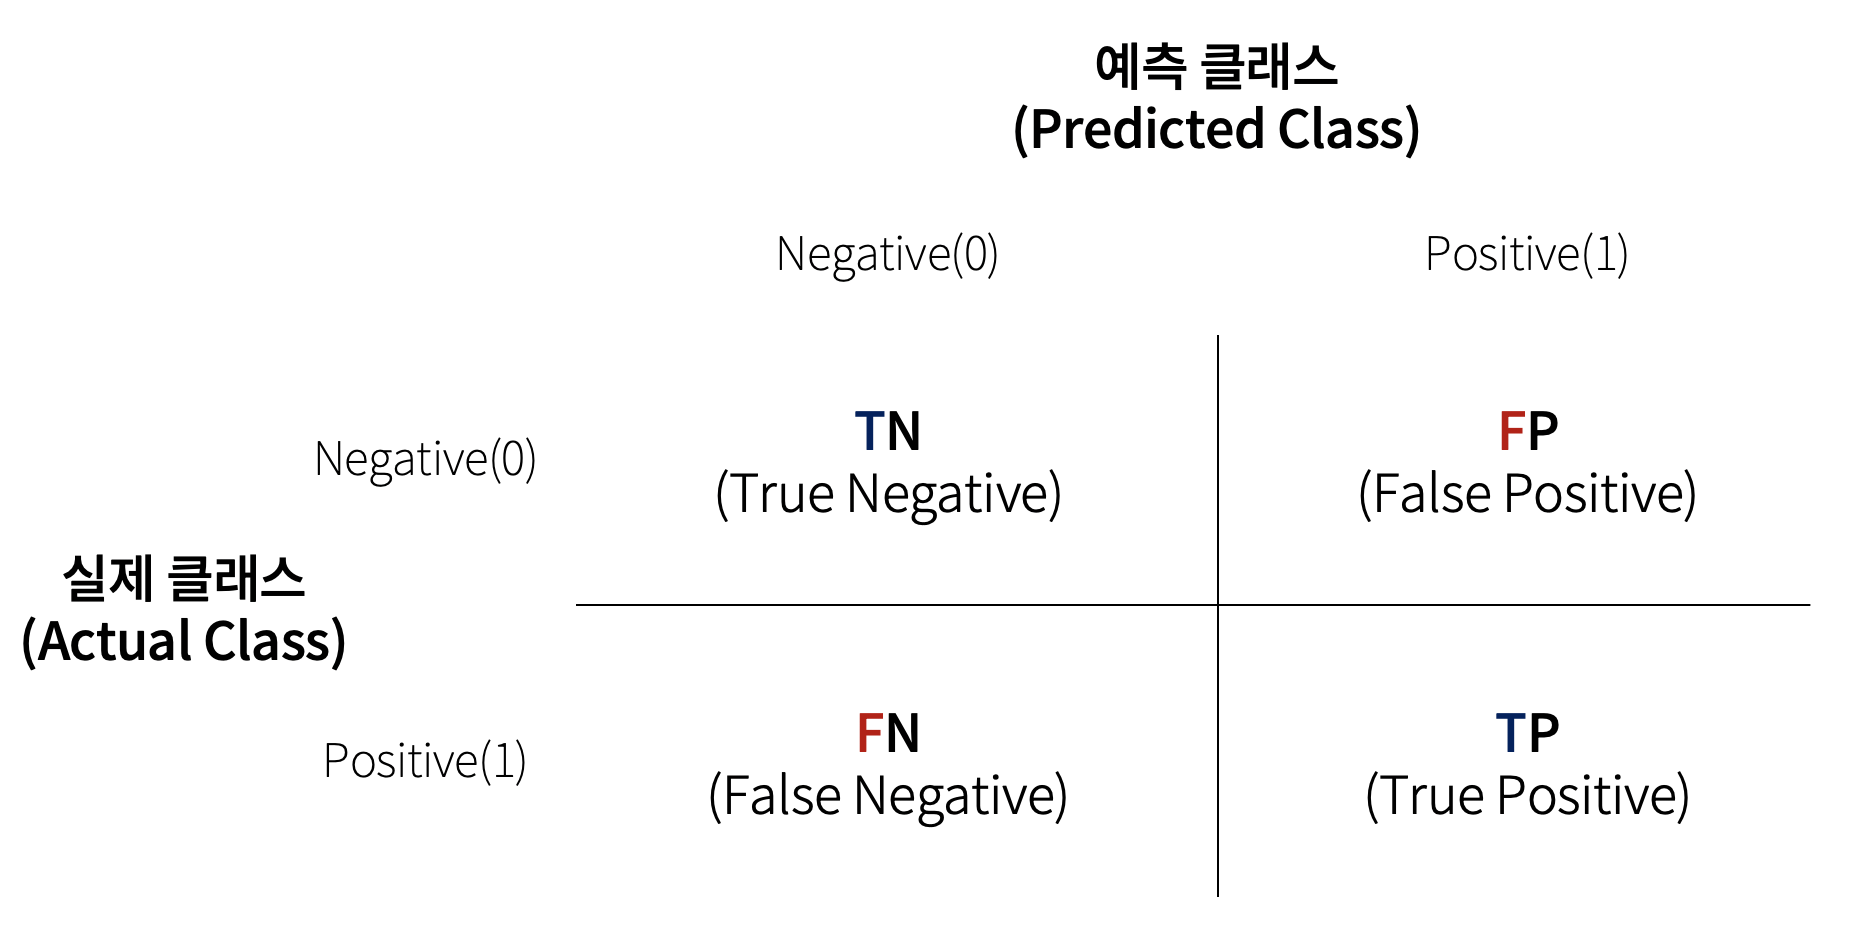
- 예측이 성공했으면, T가 붙고 실패했으면 F가 붙음
- 음성으로 예측했는데 이게 틀렸으면 FN, 양성으로 예측했는데 이게 틀렸으면 FP라고 함
- Precision(정밀도) : 양성 예측의 정확도 -> 보통 Recall(재현율)과 같이쓰임
    - Precision = (TP)/(TP+FP)
        - TP는 진짜 양성의 수 : 실제로 5이며, 분류도 5로 된 놈들
        - FP는 거짓 양성의 수 : 실제로는 5가 아니지만, 5로 분류가 된 것들
- Recall(재현율, TPR, 민감도, Sensitivity) : 분류기가 정확하게 감지한 양성 샘플의 비윯
    - Recall = (TP)/(TP+FN)
        - TP는 진짜 양성의 수
        - FN은 거짓 음성의 수 : 위 사례에서는 실제로는5지만, 5로 분류가 되지 않은 것들

## 3.3.3. 정밀도와 재현율

In [20]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.7371990505256019

In [21]:
recall_score(y_train_5, y_train_pred)

0.8020660394761114

- 정밀도와 재현율을 보니 Accuracy때보다 많이 떨어짐

##### F_score
- 정밀도와 재현율을 한 번에 보기 위한 것
- 정밀도와 재현율의 조화평균임
- F = 2*((Precision*Recall)/(Precision+Recall)) = TP/(TP+(FN+FP)/2)

In [22]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7682657478575845

- Fscore는 정밀도와 재현율이 모두 높을 때 자연스럽게 수치가 높아질 수 밖에 없음
- 그런데 Fscore가 높다고 무적권 좋은 모델이라고 볼 수 없음
    - 상황 by 상황으로 재현율이 중요할 수도 정밀도가 중요할 수도 있음
        - 예를들어 어린아이에게 안전한 동영상을 걸러내는 분류기
            - 재현율이 높더라도 정말 나쁜 동영상이 몇개 노출되는 것보다는 다소 재현율이 낮더라도 높은 정밀도로 좋은 영상 몇개를 걸러서라도, 나쁜 동영상을 일체 못보게 하는 것이 좋을 것
- 정밀도와 재현율이 둘 다 높으면 좋겠지만, 그러기는 어려움
    - Precision/Recall Trade-Off이라고 함

## 3.3.4. Precision/Recall Trade-Off
- SGDClassfifer의 임계값을 조절하며, 트레이드 오프를 확인해보자
- 해당 옵션을 바로 줄 수는 없어서, predict()메서드 대신, decision_function()메서드를 호출하여, 샘플의 점수를 확인하고, 결과값을 출력하는 방식으로 수행

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([-891634.36959735])

In [24]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [25]:
threshold = -2000000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

- 위 사례에서는 임계값을 엄청 떨어뜨리니, FT의 값을 반환하게 됨
- 책에서는 실제로 5 값인 데이터를 some_digit에 넣었고, 임계값을 많이 높이게 되니 재현율이 떨어짐을 볼 수 있었음
- 즉, 적절한 임곗값을 잘 정할 수 있어야함
- SGDClassifier의 경우 결정함수값을 얻을 수 있음. 이 값을 전체적으로 확인해보자

In [26]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [27]:
y_scores

array([-248248.40194797, -713254.84476607,  378902.67840566, ...,
       -716425.12852352, -684844.47389339, -166994.23583252])

In [28]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

- 여기서 나온 결과물로 matplotlib을 통해 임곗값의 함수로 정밀도와 재현율을 볼 수 있음

In [29]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label = "Precision")
    plt.plot(thresholds, recalls[:-1], "r--", label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = "center left")
    plt.ylim([0, 1])

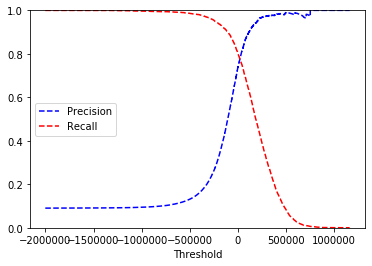

In [30]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- 위의 결과물로 최선의 정밀도/재현율 트레이드오프를 만드는 임계값을 선택해도 좋고
- 아래처럼 재현율에 대한 정밀도 곡선을 그리면 역시 정밀도/재현율의 적합한 트레이드 오프를 선택하는 데 도움을 받을 수 있음

Text(0, 0.5, 'Precision')

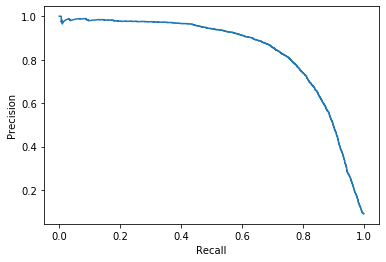

In [31]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel("Recall")
plt.ylabel("Precision")

- 대충 보면 재현율 80%선에서 정밀도가 똑 하고 떨어지기 시작함
- 이 하강점 직전을 Trade Off로 선택하는 것이 좋음
- 이 지점을 위에 Threshold Graph에서 파악하면 좋음

- 만일 정밀도 90%를 달성하는 것이 목표라고 가정해보면 위의 윗 그래프에서 임계가 70000정도라는 것을 알 수 있음.
- 이에 대한 예측을 만드려면 predict()대신 다음 코드를 활용할 것

In [32]:
y_train_pred_90 = (y_scores > 70000)

In [33]:
precision_score(y_train_5, y_train_pred_90)

0.8541387024608501

In [34]:
recall_score(y_train_5, y_train_pred_90)

0.7042980999815532

## 3.3.5. ROC Curve(Receiver Opearting Characteristic)
- 수신기 조작특성;;;;
- 이진분류에서 널리 사용하는 도구
- 정밀도/재현율 곡선 X
- 이건 거짓 양성비율(FPR)에 대한 진짜 양성비율(TPR)의 그래프임
- 즉 FPR과 TPR의 그래프
    - TPR은 Recall의 다른 이름
    - FPR = 1 - TNR
        - FPR은 양성으로 잘못 분류된 음성 샘플의 비율 : FP/(FP+TN)
        - TNR은 음성으로 정확하게 분류한 음성 샘플의 비율(진짜 음성 비율, Specificity)
            - TNR = TN/(FP+TN)
- 민감도에 대한 1-특이도의 그래프

In [35]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [36]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("FPR")
    plt.ylabel("TPR")

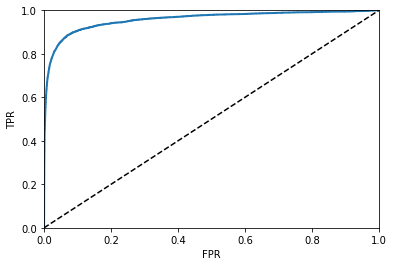

In [37]:
plot_roc_curve(fpr, tpr)
plt.show()

- 여기에도 당연히 트레이드 오프가 있음
- TPR이 높을 수록 분류기가 만드는 FPR이 늘어남
- 완전한 랜덤 분류기의 ROC Cruve는 가운데 점선의 형태임
    - 즉 좋은 분류기일 수록 해당 직선과 거리가 멀어야함(왼쪽 위 모서리 방향으로)
- AUC(곡선 아래 면적)를 측정하면 분류기를 비교할 수 있음
    - 완벽한 분류기의 경우 AUC = 1, 완전 랜덤 분류기의 경우 AUC = 0.5

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9581517134532821

- RF분류기를 만들어서 비교해보기

In [39]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 32)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3,
                                   method = "predict_proba")
#RF에는 decsision_function 대신 predict_proba(작동원리차이)

In [40]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

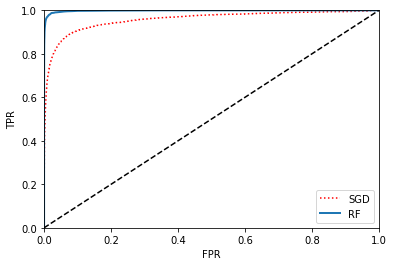

In [41]:
plt.plot(fpr, tpr, "r:", label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "RF")
plt.legend(loc = "lower right")
plt.show()

In [42]:
print("RandomForest Scores : {}".format(roc_auc_score(y_train_5, y_scores_forest)))
print("SGD Scores : {}".format(roc_auc_score(y_train_5, y_scores)))

RandomForest Scores : 0.998414019250755
SGD Scores : 0.9581517134532821


# 3.4. 다중분류
- 알고리즘마다 다르지만, RF나 Naive Bayes 분류기 같은 경우는 여러개의 클래스를 직접 처리할 수 있음
- 반면, SVM Classifier나 Logistic같은 경우에는 이진분류만 가능
    - 이런 애들은 이진분류기를 여러 개 섞어서 다중클래스를 분류할 수 있음
    - OvA 전략과 OvO 전략으로 구분됨
        - OvA : One versus All
            - 일대 다 전략
            - 특정 숫자 하나만 구분하는 숫자별 이진 분류기를 10개 훈련시키고, 클래스가 10개인 숫자 이미지 분류를 하는데, 이미지를 분류할 때 각 분류기의 결정 점수 중 가장 높은 것을 예측 클래스로 선택하는 방식
        - OvO : One Versus One
            - 일대 일 전략
            - 0과 1 구별, 0과 2 구별, ... 이런 식으로 각 숫자의 조합마다 이진분류기를 훈련시킴
            - 결국 nC2개의 이진분류기가 필요하게 됨
            - 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요함
    - SVM같은 알고리즘은 훈련세트의 크기에 민감하기 때문에, 큰 훈련세트에서 몇 개의 분류기를 훈련시키는 것 보단, 작은 여러 세트를 쪼개는 게 좋아서, OvO를 선호
    - 대부분의 알고리즘에서는 OvA를 선호
- 다중 클래스 분류 작업에서 이진분류를 선택할 경우 사이킷런이 자동으로 OvA나 OvO 중 유리한 전략을 선택해줌

In [43]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([6], dtype=int64)

In [44]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores #10개의 학습기에서 각각의 점수가 나온 것을 볼 수 있음

array([[-399121.42867858, -485490.23570562, -746647.00476282,
        -671143.18376801, -432463.96717093, -881294.25454054,
         144247.12998539, -794870.65481888, -482949.78234341,
        -723977.12313013]])

In [45]:
np.argmax(some_digit_scores)

6

In [46]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [47]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

6

- OvA혹은 OvO를 강제하려면, OneVsOneClassifier나 OnwVsRestClassifier를 이용하면 됨
- 이진 분류기 인스턴스를 만들어 객체 생성 시 인자로 전달하면 됨
- SGDClassifier를 OvO로 활용해보자

In [48]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter = 5, random_state = 42))
ovo_clf.fit(X_train, y_train)

C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaco

C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaco

OneVsOneClassifier(estimator=SGDClassifier(alpha=0.0001, average=False,
                                           class_weight=None,
                                           early_stopping=False, epsilon=0.1,
                                           eta0=0.0, fit_intercept=True,
                                           l1_ratio=0.15,
                                           learning_rate='optimal',
                                           loss='hinge', max_iter=5,
                                           n_iter_no_change=5, n_jobs=None,
                                           penalty='l2', power_t=0.5,
                                           random_state=42, shuffle=True,
                                           tol=0.001, validation_fraction=0.1,
                                           verbose=0, warm_start=False),
                   n_jobs=None)

In [49]:
ovo_clf.predict([some_digit])

array([6], dtype=int64)

In [50]:
len(ovo_clf.estimators_)

45

- RF 훈련시키기
    - RF의 경우 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 OvA나 OvO등의 전략이 필요가 없음

In [51]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([6], dtype=int64)

In [52]:
forest_clf.predict_proba([some_digit])

array([[0.02, 0.  , 0.02, 0.  , 0.  , 0.  , 0.95, 0.  , 0.01, 0.  ]])

- 
    - 갱장히 강려크한 확률로 정답을 확신하고 있음
    - 무려 6을 97%로 추정하고 있음

In [53]:
cross_val_score(sgd_clf, X_train, y_train ,cv = 3, scoring = "accuracy")

C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.8684 , 0.85955, 0.87275])

- 성능이 아주 나쁘진 않지만, 더 성능을 높일 여지가 있음
- 입력의 스케일을 조정해보자

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.91175, 0.91015, 0.9098 ])

# 3.5. 에러분석

- 실제 프로제그라면, 데이터 준비 단계에서 선택사항을 탐색하고, 여러 모델을 시도하고, 가장 좋은 몇 개를 골라서 GridSearchCV등을 통해 하이퍼파라메터 튜닝을 실시하고, 가능한한 자동화했을 것
- 가능성이 높은 모델을 하나 찾았다고 가정하고, 성능 향상 방법을 고민해보겠음
    - 그 중 한가지 방법이 만들어진 에러의 종류를 분석하는 것!

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\shark1375\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5732,    2,   21,   12,   10,   49,   49,    8,   36,    4],
       [   2, 6461,   49,   28,    6,   44,    8,   13,  120,   11],
       [  56,   37, 5331,   97,   76,   26,   89,   62,  168,   16],
       [  40,   40,  131, 5371,    2,  211,   31,   59,  149,   97],
       [  20,   26,   38,   10, 5362,    8,   51,   31,   80,  216],
       [  65,   40,   37,  201,   72, 4609,  101,   25,  177,   94],
       [  32,   22,   45,    3,   37,   94, 5629,   11,   45,    0],
       [  22,   18,   70,   25,   51,   14,    7, 5827,   16,  215],
       [  44,  148,   74,  169,   12,  168,   54,   26, 5017,  139],
       [  43,   30,   24,   85,  153,   33,    2,  202,   82, 5295]],
      dtype=int64)

- 오차행렬은 matshow함수를 활용하여 시각화해서 보면 편리

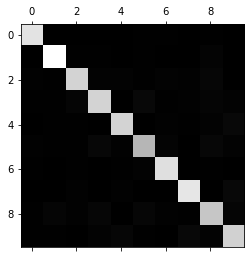

In [56]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

- 주대각선을 보면 숫자 5가 다른 부분에 비해 다소 그래이색이야!
- 두 가지 경우의 수를 생각할 수 있음
    - 1) 5 데이터가 좀 적거나
    - 2) 5 자체를 잘 분류하지 못하거나
- 주 대각선 이외 그래프의 에러 부분에 초점을 맞춰보자
- 오차행렬의 각 값을 대응되는 클래스의 이미지 개수로 나누어 에러 비율을 비교
    - 개수로 비교하면 이미지가 많은 클래스가 당연히 오류 이미지 자체가 많아, 나빠보일 것

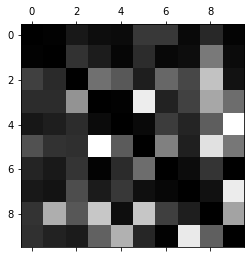

In [57]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)
plt.show()

- 흰색 부분이 에러 비율이 높았던 놈들임
- Diagonal 제대로 분류 된 애들은 0으로 채워서 검정색으로 나옴
- 행은 실제 클래스, 열은 예측 클래스임
- 클래스 8과 9의 열이 갱-장히 밝음
    - 많은 이미지가 8과 9로 잘못 분류된 것
- 또한 8과 9의 행이 꽤 밝음
    - 8과 9가 다른 클래스로 많이 분류된 것
- 1은 꽤 어두움
- 그리고, 에러가 diagonal 인자에 대칭이 아니라는 점도 꼭 기억해야함

- 오차행렬을 이렇게 뜯어보면, 인사이트를 얻을 수 있음
    - 3과 5에 많은 혼동이 있음
    - 그리고 8, 9와 전반적인 숫자들의 분류를 개선해야함
        - 이 부분에 대해 데이터를 더 모으거나, 분류기에 도움될만한 특성을 더 찾아볼 수 있음
        - ex) 동심원의 개수를 세는 알고리즘
        - ex) 또는 동심원같은 어떤 패턴이 더 드러나도록 이미지 전처리(Open CV 등 활용)
- 개개의 에러를 분석해보면, 분류기가 무슨 일을 하고, 왜 잘못되었는지 알 수 있기는 하지만 더 오래걸림.
- 위에서처럼 전반적으로 훑어보고 상세히 내려가는 방식을 선택할 것

# 3.6. 다중 레이블 분류
- 지금까지는 각 샘플이 하나의 클래스에만 할당 됨
- 하지만, 여러 개의 클래스를 출력해야할 수도 있음
     - ex) 얼굴 인식 분류기 : 같은 사진에 여러 사람이 등장 -> 인식된 사람마다 레이블을 하나씩 할당해야함
     - ex) 밥, 찰리, 앨리스 분류기 -> [0, 0, 1] 이런 식으로 출력해야함
- 이렇게 여러 개의 이진 레이블을 출력하는 분류시스템이 다중 레이블 분류시스템임

In [58]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [59]:
knn_clf.predict([some_digit])

array([[False, False]])

- 평가 방법은 다양함
- 예를들어 F1 Score를 각 레이블마다 구하고(또는 어떤 이진 분류 지표를 사용하고) 간단하게 평균 점수를 계산할 수있음

In [61]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3, n_jobs = -1)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

0.977317526453761

- 지금 이 모델의 경오 모든 레이블의 가중치가 같다고 가정한 것
- 만약, 특정 인물의 사진이 너무 많다는 문제 등이 있을 경우, 특정 분류기에 더 높은 가중치를 둘 것
    - 지금은 단순히 F1의 평균 수행(average = "macro")
- 간단한 방법은 레이블에 Class의 지지도(Support)를 가중치로 주는 것
    - 지지도 : 타깃 레이블에 속한 샘플 수
    - 이렇게 하려면 이전 코드에서 average = "macro"대신 averge = "weighted"로 설정하면 됨

# 3.7. 다중출력분류
- 마지막으로 알아볼 분류작업임
- 다중 출력 다중 클래스 분류(Multioutput Multiclass Classification, 다중출력분류 : Multioutput Classification)
- 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화 한 것으로 결과 값을 두 개 이상 가질 수 있는 것

- 이미지에서 노이즈를 제거하는 시스템을 만들어보자
    - 노이즈가 많은 숫자 이미지를 인풋으로 받고, 깨끗한 숫자 이미지를 담은 배열을 출력
    - 분류기의 출력이 픽셀별로 나오므로 자연스럽게 다중 레이블이 될 것이며, 각 레이블은 0~255까지의 픽셀 강도를 가지므로, 다중 출력 분류 시스템이 되는 것

In [69]:
from numpy import random as rnd

In [70]:
# 픽셀에 노이즈 추가
noise = rnd.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = rnd.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

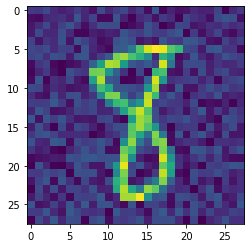

In [95]:
plt.imshow(X_train_mod[0].reshape(28, 28))
plt.show()

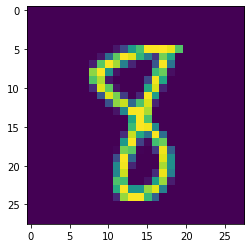

In [96]:
plt.imshow(y_train_mod[0].reshape(28, 28))
plt.show()

In [98]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])

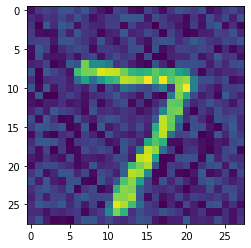

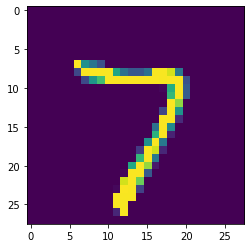

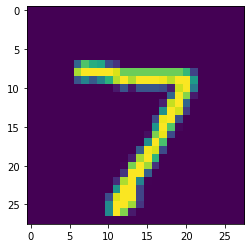

In [102]:
plt.imshow(X_test_mod[0].reshape(28, 28))
plt.show()
plt.imshow(clean_digit.reshape(28, 28))
plt.show()
plt.imshow(y_test_mod[0].reshape(28, 28))
plt.show()

- 매우 비슷햊진것을 확인할 수 있음